# Astronomy 8824 - Numerical and Statistical Methods in Astrophysics

## Statistical Methods Topic VI. Estimating Errors From Data

These notes are for the course Astronomy 8824: Numerical and Statistical Methods in Astrophysics. It is based on notes from David Weinberg with modifications and additions by Paul Martini.
David's original notes are available from his website: http://www.astronomy.ohio-state.edu/~dhw/A8824/index.html

#### Background reading: 
- Statistics, Data Mining, and Machine Learning in Astronomy, $\S 4.5$

In [1]:
import math
import numpy as np
from numpy.polynomial import Polynomial
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import norm

# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

LaTex macros hidden here -- 
$\newcommand{\expect}[1]{{\left\langle #1 \right\rangle}}$
$\newcommand{\intinf}{\int_{-\infty}^{\infty}}$
$\newcommand{\xbar}{\overline{x}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\like}{{\cal L}}$
$\newcommand{\llike}{{\rm ln}{\cal L}}$
$\newcommand{\xhat}{\hat{x}}$
$\newcommand{\yhat}{\hat{y}}$
$\newcommand{\xhati}{\hat{x}_i}$
$\newcommand{\yhati}{\hat{y}_i}$
$\newcommand{\sigxi}{\sigma_{x,i}}$
$\newcommand{\sigyi}{\sigma_{y,i}}$
$\newcommand{\cij}{C_{ij}}$
$\newcommand{\cinvij}{C^{-1}_{ij}}$
$\newcommand{\cinvkl}{C^{-1}_{kl}}$
$\newcommand{\cinvmn}{C^{-1}_{mn}}$
$\newcommand{\valpha}{\vec \alpha}$
$\newcommand{\vth}{\vec \theta}$
$\newcommand{\ymod}{y_{\rm mod}}$
$\newcommand{\dy}{\Delta y}$

### Estimating Errors from Data

Do error bars belong on the data, or on the model? 

**Bayesian:** Error bars belong on the model. Data are not random variables, although they are drawn from a pdf. Evaluate the probability of the model (or hypothesis), given the data.

**Frequentist:** Error bars belong on the data. Data are random variables. Evaluate the probability of obtaining the data, that is the fraction of times you would get some result, given the model (or hypothesis). 

### Where does the error bar go? 

##### Here is an example of putting the error bar on the model

Suppose you measure the average depression of flux in a quasar caused by absorption from the Lyman-alpha forest.  This is called the flux decrement, and is equal to 

$$
D_A = 1 - F_A = 1 - e^\tau
$$
 
where $\tau$ is the optical depth, and is related to the neutral hydrogen density, the temperature of the IGM, and the ionization rate as $\tau \propto n_H^2 T^{-0.7} \Gamma^{-1}$. 


Imagine you find that 30\% of the flux is absorbed, $D_A=0.3$.

You have two models that predict $D_A=0.32$ and $D_A=0.4$, respectively. Which do the data favor?  Is either ruled out?

We can't answer this yet, as we need to also know how much variation the two models predict. Why? Because different models may predict different amounts of variations. 

If the first model predicts $D_A=0.32$ on average and an rms variation of $0.002$ from one quasar to another, then the predicted $D_A=0.32 \pm 0.002$ is strongly inconsistent with the observed $D_A=0.3$, unless the predicted distribution of variations is highly non-Gaussian.

If the second model predicts $D_A=0.4$ on average and an rms variation of 0.05 from one quasar to another, then its prediction $D_A=0.4 \pm 0.05$ is marginally inconsistent with your measurement.  
The data favor this model even though its mean prediction is further from the observed value.

**Note:** Be careful about usage. The prediction of rms variation, or model dispersion, is *not* an error bar on the parameter. 

This example illustrates the Bayesian insistence that error bars really belong _on the model_, not on the data, since different models may predict different error bars for the same data set.

But suppose we measure the decrement for 20 quasars instead of one, and we find a mean of 0.3 and an rms variation about the mean of 0.05.  

Here it seems legitimate to say that the uncertainty on the mean is $0.05/\sqrt{20}=0.01$, and that our measurement implies $D_A=0.3 \pm 0.01$. (This puts an uncertainty on a measured quantity, so it is non-Bayesian.)

What allows us to attach an error bar to the data, and to implicitly claim that it is model independent?  

In effect, this procedure relies on the assumption (which should be good in this case) that any model that will fit the data must also predict an rms variation similar to the value $0.05$ that you measured, and that it will therefore predict an error on the mean for a sample of 20 quasars that is close to $0.05/\sqrt{20}$.

Now consider a model that predicts a mean of $D_A=0.35$ and an rms quasar-to-quasar variation of $0.3$. This predicts that we should measure a mean value of $D_A=0.35 \pm 0.06$ for a sample of 20 quasars.  But although its mean prediction is consistent with the measured mean within its expected error, the rms variation of $0.3$ for this model is inconsistent with the measured rms variation of 0.05, so the model is ruled out, or at least disfavored, on other grounds. (To decide just how inconsistent the model is, we would need to calculate the error bar on the rms variation.)

For quantities that are well measured (i.e., determined to fairly high fractional precision), it is usually okay to "transfer" the error bar to the data in this way because the data have sufficient power to constrain the variation within the sample and yield an estimated error bar that must be close to that of any model that would be
consistent with the data.

However, you should be very cautious about "transferring" the error bar in any case where the estimated fractional uncertainty is large. In these cases, the error bar is often highly model dependent.


### Small Number Statistics

The extreme, and often relevant, example is a survey that turns up one object of a certain class.  

It is tempting to say that the measured number of objects is $1 \pm 1$ and therefore consistent with zero.

It is true that a model that predicts a mean of one object in a survey of this size predicts (assuming Poisson statistics) that a fraction $e^{-1} = 0.37$ of such surveys would detect no objects, and that a model that predicts a mean of two objects predicts that $2^1 e^{-2}/1! = 0.27$ of such surveys should yield one object and is therefore consistent with the data.

However, if we have a model that predicts a mean of 0.001 objects, then it predicts that only $0.001^1 e^{-0.001}/1! = 0.001$ of such surveys should yield one object, so it is ruled out (or at least strongly disfavored).

A model that predicts a mean of 10 objects is also strongly disfavored, as $P(k=1|\mu=10) = 10^1 e^{-10} = 4.5 \times 10^{-4}$.

Even with very small numbers of objects, one can make statistically interesting statements about some models.

#### Low-background example

This example is relevant to data analysis with very low backgrounds (e.g. _Chandra_). 

Suppose that the background is very low, e.g., $10^{-4}$ counts/pixel in a 50 ksec exposure.

If you have $10^6$ pixels, there will be $\sim 100$ background counts, so a single-photon detection isn't significant.

However, the probability of getting 2 background photons in a pixel is $10^{-8}$, so there should be only $0.01$ pixels out of $10^6$ with two background photons by chance.

Therefore, 2 counts in a single pixel would be a statistically significant detection of an object.

Also, if you knew ahead of time where you were going to look (e.g., at a recent TDE) to within a pixel, then even a single photon detection would be significant at the $10^{-4}$ level, and would rule out a model that predicted only $10^{-3}$ source counts in a 50 ksec exposure.

$$
P(k=1) = \frac{0.001^1 \exp^{-0.001}}{1!} = 0.001
$$
In words, the probability of one count when $10^{-3}$ are expected is $P(k=1) = 0.001$.

**Moral:** Don't automatically discount small number statistics, though you should use them with caution.


### Estimating error bars from the data: subsample, jackknife, bootstrap

In a case like the average quasar flux decrement example, it is obvious how to estimate the error bar from the data using the rms variation.

But suppose we are doing something more complicated, e.g., measuring the power spectrum of the flux (a 1-d function) after fitting a  continuum to each spectrum, removing metal lines, and subtracting photon noise.  We have done some complicated processing, and the signal-to-noise of the measurement in each individual spectrum may be quite different from one quasar to another.

It may not be obvious how to estimate an error bar from the data using the rms variation. It is not always correct to assume Gaussianity. 

Here are three ways to estimate an error bar: 


#### Subsample

One way to proceed in a complicated case like this is to divide the data into subsamples, say five groups of four quasars each. You can then apply your measurement separately to each subsample and estimate errors from the subsample-to-subsample variation.

For example, you now have $N=5$ estimates $^kP_i$ of the power spectrum on spatial scale $i$, where $k=1,...N$.  You can estimate the error bar $\sigma_{ii}$ on $P_i$ as
$$
\sigma^2_{ii} = {1 \over N-1} \sum_{k=1}^N {(^kP_i - \bar{P_i})^2 \over N},
$$
where $\bar{P_i}$ is your estimate from the full sample of all quasars.

You might also want to estimate the covariance of errors from two different length scales $i$ and $j$:
$$
\sigma^2_{ij} = {1 \over N-1} \sum_{k=1}^N 
  {(^kP_i - \bar{P_i})(^kP_j-\bar{P_j}) \over N}.
$$

(Some covariance is expected due to the correlated errors in the measurement of the power spectrum.)

#### Jackknife

The subsample approach can lead to problems if you really need something close to your full sample size to get a usable measurement in the first place, so that the estimates from your much smaller subsamples are  wildly varying.  (This is especially problematic if, for instance, you know that the quantity you are measuring is positive-definite
but noise means that you can get negative values in individual measurements.)

An attractive, more robust alternative is jackknife error estimation, where you _omit_ each subsample in turn, and apply your measurement to all of the _remaining_ data.  

For example, imagine you want to measure the parameter $\alpha$, and $\alpha^N$ is the value of $\alpha$ if measured from all $N$ data points. We can create $N$ datasets that each are missing one measurement $i$ called $\alpha^*_i$. The bias-corrected jackknife estimate of $\alpha$ is:
$$
\alpha^J = \alpha_N + \Delta \alpha = \alpha_N + (N-1) \left( \alpha_N - \frac{1}{N} \sum^N \alpha^*_i \right)
$$

For the previous case with the power spectrum the variance is:
$$
\sigma^2_{ii} = {N-1 \over N} \sum_{k=1}^N (^kP_i - \bar{P_i})^2 ,
$$
where $^kP_i$ now represents the estimate of $P_i$ after subsample $k$ is _omitted_ from the data sample.

The pre-factor is larger by a factor of $(N-1)^2$, but the variation $(^kP_i - \bar{P_i})$ is smaller because each subset $k$ is now closer to the full sample.

In the case we are considering, the individual subsamples could now be single quasars, so we could set $N=20$ and omit each quasar in turn.

Where the jackknife and subsample error estimates would give different answers, I think the jackknife estimate is generally preferable.

#### Bootstrap

A widely used variant on the same theme is bootstrap resampling. Here you create new samples that are the same size as the original data sample by drawing from that sample _with replacement._

For example, $N$ bootstrap samples of $20$ quasars randomly drawn from the original set of $20$, but one of the boostrap samples may contain quasar 1 three times, quasar 2 twice, and quasar 3 not at all, etc. 

The error bars are simply computed from the dispersion among the $N$ bootstrap samples,
$$
\sigma^2_{ii} = \sum_{k=1}^N {(^kP_i - \bar{P_i})^2 \over N},
$$
where $\bar{P_i}$ is the estimate from the full sample, not the mean of the bootstrap samples, and $^kP_i$ are the bootstrap samples.  There is no pre-factor because now each bootstrap sample is the same size as the full sample.

Important: boostrap and jackknife are generally less (or not at all) sensitive to measures of outliers, e.g. quartiles, although this can be overcome by removing multiple points (subsamples $> 1$). 

Bootstrapping seems to be moderately preferred by the cognoscenti over subsampling or jackknife, but the fact that it involves replacement (and a bootstrap sample therefore has some identical elements) can cause problems in some cases, so think about what you are doing.

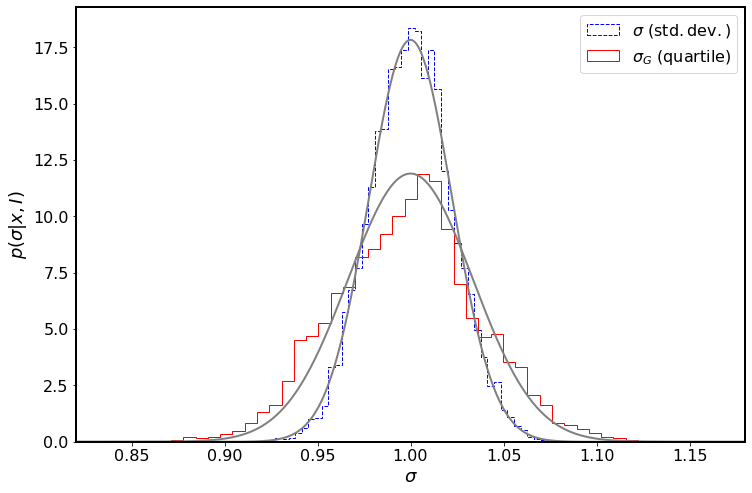

In [2]:
# https://www.astroml.org/book_figures/chapter4/fig_bootstrap_gaussian.html
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.resample import bootstrap
from astroML.stats import sigmaG

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#if "setup_text_plots" not in globals():
#    from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

#------------------------------------------------------------
# Compute bootstrap resamplings of data
mu1_bootstrap = bootstrap(data, n,  np.std, kwargs=dict(axis=1, ddof=1))
mu2_bootstrap = bootstrap(data, n, sigmaG, kwargs=dict(axis=1))

#------------------------------------------------------------
# Compute the theoretical expectations for the two distributions
x = np.linspace(0.8, 1.2, 1000)

sigma1 = 1. / np.sqrt(2 * (m - 1))
pdf1 = norm(1, sigma1).pdf(x)

sigma2 = 1.06 / np.sqrt(m)
pdf2 = norm(1, sigma2).pdf(x)

#------------------------------------------------------------
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(mu1_bootstrap, bins=50, density=True, histtype='step',
        color='blue', ls='dashed', label=r'$\sigma\ {\rm (std. dev.)}$')
ax.plot(x, pdf1, color='gray')

ax.hist(mu2_bootstrap, bins=50, density=True, histtype='step',
        color='red', label=r'$\sigma_G\ {\rm (quartile)}$')
ax.plot(x, pdf2, color='gray')

ax.set_xlim(0.82, 1.18)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')

ax.legend()

The figure above shows the bootstrap uncertainty estimates of the standard deviation for a Gaussian distribution with $\sigma = 1$ and $\mu = 0$. The dashed line is the sample standard deviation and the solid line is $\sigma_G$. The thin, smooth curves show the Gaussians for $s/\sqrt{2(N-1)}$ and $1.06s/\sqrt{N}$. Note that $\sigma_G = 0.7413(q_{75} - q_{24})$ is an estimate of the width based on the interquartile range.

#### General Remarks

All of these approaches are implicitly "transferring" the error bars as discussed above.  We are implicitly assuming that any model that would actually fit the data would have a similar distribution and would therefore predict similar errors.

The idea behind all three is that the data are drawn from some distrbution $h(x)$ and that we can estimate that $h(x)$ from the data directly.  Each subsample (or jackknife sample, or bootstrap sample) is drawn from this distribution, so we get an internal estimate of what variation is expected in data drawn from this distribution.

A critical assumption for any of these methods is that the individual subsamples are _independent_.  

For the quasar case described above, this assumption is probably fine, since the regions of the universe sampled by different quasars are far enough apart that they are uncorrelated.

Suppose we are instead trying to estimate uncertainties in the galaxy correlation function measured from a redshift survey.

Each galaxy is a separate data point, but they are highly correlated because they trace the same underlying structure (e.g., the same clusters and superclusters).

Using subsamples, jackknife, or bootstrap with individual galaxies would severely underestimate the errors.

For this case, we need to define subsamples that are spatially contiguous volumes, large enough that the estimates of the correlation function in each subsample are independent.  Roughly speaking, we want to be sure that the spatial size of each subsample is large compared to the largest coherent structures that are found in the universe.

For an example of this approach, see Zehavi et al. (2005), ApJ, 630, 1

#### Error bars from artificial data sets 

If we have a model that we want to test, and we can generate complete, independent artificial data sets from the model, then it is better to estimate errors and covariances from large numbers of mock data sets instead of using these "internal" techniques to estimate errors and covariances.

For example, it is now common practice to create artificial mock galaxy catalogs from cosmological simulations to estimate errors and covariances for galaxy clustering measurements.

Yet this can be very computationally demanding, and developing  efficient tools for creating simulated data sets that are "accurate enough" for evaluating errors can be a research problem in itself. It is not uncommon to see multiple papers on mock catalogs connected with major cosmological analyses. 

In principle one should generate different sets of mock catalogs for all models being tested, or evaluate the dependence of the covariance matrix on model parameters.

The accuracy required to estimate errors is usually lower than the accuracy required to evaluate parameters by fitting a model to the data.

In practice this approach is usually applied for a fiducial model that is expected to represent the properties of the data reasonably well.

Another approach is to compute models for a discrete set of model values and interpolate between these values. This process is called emulation. 

### Noise and bias in covariance matrices

Recall that the sample covariance matrix is

$$
C = \frac{1}{N-1} \sum^N (\bar{x}_i - \bar{x}) (\bar{x}_j - \bar{x})^T
$$
In this case $N$ is the number of data points, and the model has $k$ parameters, so $C$ is a $k \times k$ matrix. 

Whether one is using an internal method or artificial data sets, one should be aware of the potential problem of noise in the estimated covariance matrix, since one may be estimating large numbers of $\sigma_{ij}$.

Even if the individual estimates are unbiased, noise may cause some of them to be artificially large.  Since it is the inverse of the covariance matrix that gets used in evaluating the likelihood, noisy estimates of the covariance matrix can cause misleading conclusions about best-fit parameter values, parameter uncertainties, or relative merit of models.

If you have an idea of what the general structure of the covariance matrix should be, you can impose "regularization" constraints to reduce noise.  See  Padmanabhan et al. (2016, MNRAS 460, 1567, arXiv:1512.01241) and references therein for a recent discussion.

### Cosmology Example

A somewhat separate problem is that the inverse covariance matrix estimated from a finite number of artificial data sets or subsamples can be systematically biased.  This problem (and a partial solution) is discussed by Hartlap \& Schneider (2007, A\&A 464, 399) and by Paz \& Sanchez (2015, MNRAS 454, 4326).

Imagine you have some dataset $\bar{D}$ that are measurements, for example of the power spectrum or the 2PCF. It is common to assume the data are drawn from multivariate Gaussians described by some mean $\expect{D}$ and covariance matrix $C$. 

Take a model $T(\theta) = \expect{D} (\vec \theta)$ with parameters $\vec \theta$. The probability of the data is a realization of the model is:  
$$ 
\mathcal{L} (\bar{D} | \theta\,\psi) = |\psi|^{1/2} \exp \left( -\frac{1}{2} \chi^2(\bar{D} \bar{\theta}, \Psi) \right)
$$

$\Psi = C^{-1}$ is inverse of the covariance and is often called the precision matrix. 

$\chi^2 = \sum_{i,j} (D_i - T_i (\theta) ) \Psi_{i,j} (D_j - T_j (\theta) )$

One needs to know $\Psi$ to evaluate $\chi^2$ and $\mathcal{L}$. It is common to derive these quantities from mock datasets $\bar{D}^k$ with some $N_s$ number of measurements. 

An unbiased estimate of this covariance matrix is:

$$
\hat{C}_{ij} = \frac{1}{N_s - 1} \sum^{N_s}_{k=1} (D^k_i - \bar{D}_i) (D^k_j - \bar{D}_j)
$$

where $\bar{D}_i = \frac{1}{N_s} \sum_k D^k_i$ is an unbiased estimate of $\bar{D}_i$. 

With in-depth realizations, the uncertainties for $C$ and $\Psi$ follow a Wishhart distribution, and the inverse is asymmetric so that the bias-corrected estimate of the precision matrix is: 
$$
\hat{\Psi} = \left( 1 + \frac{N_b + 1}{N_s + 1} \right) \hat{C}^{-1}
$$
for $N_b$ bins of $\hat{D}$. 

This estimate is based on some finite number of synthetic datasets, so it will be affected by noise. See the papers above for more discussion of this point.